In [1043]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import wandb
import numpy as np
from nb_funcs import init_mpl
init_mpl()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from nb_funcs import (
    get_wandb_runs_table, get_review_from_eval_set, get_model_from_run, get_review_from_model_name,
    REVIEW_LABELS, get_results_df_for_run
)

In [4]:
def get_fine_tuned_models_for_seed(seed, project='ft-new-reviews'):
    api = wandb.Api()
    runs = api.runs(f'tberm-org/{project}')
    runs = [run for run in runs if run.config['train_config'].get('seed') == seed]
    rows = []
    for run in runs:
        model = get_model_from_run(run)
        if model.file_count < 4:
            continue
        rows.append({
            'review': get_review_from_model_name(model.name),
            'model': model.name
        })
    return pd.DataFrame(rows).sort_values('review')
        

### Evaluating transfer of expert fine-tuned on one review to another review

* For each given training review and evaluation review and for each training mode (described below) there are three wandb runs each differing only by the random initialisation of the LoRA weights (determined by `adapters_seed` which is $\in \{1,2,3\}$
* Details of runs where the training and evaluation reviews differ are stored in the `xeval_` data frames. `_sm` corresponds to training with equally sized (small) training datasets. `_lg` corresponds to training with the full datasets (which are of different sizes for different reviews). `_cc` corresponds to training with "contrastive criteria", i.e. some examples consisted of a paper title and abstract from the training review dataset paired with inclusion criteria for a _different_ review, and labelled as "exclude" (this approach turned out not to work well).
* Details of runs where training and evaluation are on the same review are stored in the `same_eval_` datasets. For these runs, 5-fold cross-validation was used and each fold evaluation corresponds to a separate wandb run.
* `bl_df` contains zero-shot evaluation runs of the base model on each review, which serve as baselines.  

In [103]:
from nb_funcs import make_df_from_wandb_runs

summary_cols = ['acc', 'recall', 'neg_recall', 'precision', 'pos_rate', 'average_precision', 'auroc', 'split_a_average_precision', 'split_a_auroc', 'split_b_average_precision', 'split_b_auroc']
config_cols = {'run_config/eval_set': 'eval_set', 'run_config/load_adapter': 'trained_model', 'run_config/adapters_seed': 'adapters_seed'}

api = wandb.Api()
runs = [
    run for run in api.runs('tberm-org/cross-review-eval-sm')
    if run.config['run_config'].get('adapters_seed') is not None
]
xeval_sm_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)

xeval_sm_df['train_review'] = xeval_sm_df.trained_model.apply(get_review_from_model_name)
xeval_sm_df['eval_review'] = xeval_sm_df.eval_set.apply(get_review_from_eval_set)
xeval_sm_df = xeval_sm_df[xeval_sm_df.train_review != xeval_sm_df.eval_review]

len(xeval_sm_df)

147

In [104]:
runs = [
    run for run in api.runs('tberm-org/cross-review-eval-lg')
    if run.config['run_config'].get('adapters_seed') is not None
]
xeval_lg_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)

xeval_lg_df['train_review'] = xeval_lg_df.trained_model.apply(get_review_from_model_name)
xeval_lg_df['eval_review'] = xeval_lg_df.eval_set.apply(get_review_from_eval_set)
xeval_lg_df = xeval_lg_df[xeval_lg_df.train_review != xeval_lg_df.eval_review]

In [226]:
from nb_funcs import make_df_from_wandb_runs

summary_cols = ['acc', 'recall', 'neg_recall', 'precision', 'pos_rate', 'average_precision', 'auroc']
config_cols = {'run_config/eval_set': 'eval_set', 'run_config/load_adapter': 'trained_model', 'run_config/adapters_seed': 'adapters_seed'}

api = wandb.Api()
runs = [
    run for run in api.runs('tberm-org/cross-review-eval-sm-cc')
]
xeval_sm_cc_df = make_df_from_wandb_runs(runs, config_cols, summary_cols)

xeval_sm_cc_df['train_review'] = xeval_sm_cc_df.trained_model.apply(get_review_from_model_name)
xeval_sm_cc_df['eval_review'] = xeval_sm_cc_df.eval_set.apply(get_review_from_eval_set)
xeval_sm_cc_df = xeval_sm_cc_df[xeval_sm_cc_df.train_review != xeval_sm_cc_df.eval_review]
len(xeval_sm_cc_df)

98

In [40]:
xeval_cc_df = xeval_df[xeval_df['name'].str.contains('-cc')]
xeval_df = xeval_df[(~xeval_df['name'].str.contains('-cc')) & (~xeval_df['name'].str.contains('jasmine'))]

In [284]:
config_cols = {'run_config/eval_set': 'eval_set'}
bl_df = get_wandb_runs_table('tberm-org/zero-shot-baselines-full', config_cols, summary_cols)
bl_df['review'] = bl_df['eval_set'].apply(get_review_from_eval_set)
bl_df = bl_df.set_index('review')
bl_df

,name,acc,recall,neg_recall,precision,pos_rate,average_precision,auroc,split_a_average_precision,split_a_auroc,split_b_average_precision,split_b_auroc,eval_set
review,,,,,,,,,,,,,
258698,258,0.938269,0.753247,0.943916,0.290727,0.076731,0.579834,0.958245,0.573270,0.961070,0.553305,0.955181,data/covidence/review_258698/trunc_full.txt
121733,121,0.779730,0.438662,0.974522,0.907692,0.175676,0.819144,0.882308,0.843318,0.885678,0.802986,0.879065,data/covidence/review_121733/trunc_full.txt
378562,378,0.880249,0.479592,0.952294,0.643836,0.113530,0.612577,0.890695,0.609400,0.904262,0.594924,0.873514,data/covidence/review_378562/full.csv
334317,334,0.818328,0.777778,0.819533,0.113557,0.197709,0.282620,0.867489,0.190714,0.841517,0.426751,0.892011,data/covidence/review_334317/full.csv
288055,288,0.920348,0.307692,0.932103,0.080000,0.072411,0.124815,0.874340,0.287996,0.911601,0.073397,0.835489,data/covidence/review_288055/full.csv
287708,287,0.824265,0.546875,0.888587,0.532319,0.193382,0.572476,0.836313,0.550764,0.836716,0.554952,0.836065,data/covidence/review_287708/full.csv
165805,165,0.915358,0.380753,0.977594,0.664234,0.059773,0.549595,0.867273,0.610673,0.891272,0.478525,0.841480,data/covidence/review_165805/full.csv
117787,117,0.916541,0.394366,0.978956,0.691358,0.060902,0.564796,0.898519,0.582039,0.911201,0.569494,0.883506,data/covidence/review_117787/full.csv


In [297]:
config_cols = {'train_config/train_set': 'train_set', 'train_config/fold': 'fold'}
same_eval_lg_df = get_wandb_runs_table('tberm-org/ft-cross-val', config_cols, summary_cols)
same_eval_lg_df['train_review'] = same_eval_lg_df.train_set.apply(get_review_from_eval_set)
# get rid of small review
same_eval_lg_df = same_eval_lg_df[same_eval_lg_df.train_review != 378562]
same_eval_lg_df = same_eval_lg_df.groupby('train_review').agg({'average_precision': ['mean', 'std']})
same_eval_lg_df.loc[378562] = np.nan
same_eval_lg_df

average_precision          
                          mean       std
train_review                            
117787                0.721554  0.039044
121733                0.944237  0.008433
165805                0.709983  0.060394
258698                0.718066  0.041396
287708                0.728276  0.049850
334317                0.419531  0.166715
378562                     NaN       NaN

In [367]:
config_cols = {'train_config/train_set': 'train_set', 'train_config/fold': 'fold'}
same_eval_sm_df = get_wandb_runs_table('tberm-org/ft-cross-val-sm', config_cols, summary_cols)
same_eval_sm_df['train_review'] = same_eval_sm_df.train_set.apply(get_review_from_eval_set)
# get rid of small review
same_eval_sm_df = same_eval_sm_df[same_eval_sm_df.train_review != 378562]
same_eval_sm_df = same_eval_sm_df.groupby('train_review').agg({'average_precision': ['mean', 'std']})
same_eval_sm_df.loc[378562] = np.nan
same_eval_sm_df

average_precision          
                          mean       std
train_review                            
117787                0.646964  0.096452
121733                0.908759  0.039675
165805                0.683241  0.025714
258698                0.703165  0.053110
287708                0.671351  0.030960
334317                0.382288  0.069085
378562                     NaN       NaN

In [1046]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors


def draw_heatmap(xeval_df, baseline_df, same_eval_df, metric, absolute=False, norm_cols=False, fixed_order=True, no_plot=False, use_labels=True):
    if absolute and norm_cols:
        raise Exception('Cannot do both absolute and norm_cols')
    val_rows = []
    err_rows = []
    train_rev_ids = np.array(xeval_df.train_review.unique())
    # make sure that any extra eval reviews are at end of array so that elements
    # that are in both have the same index in both
    eval_rev_ids = np.concatenate([
        train_rev_ids, list(set(xeval_df.eval_review.unique()) - set(train_rev_ids))
    ])
    for review_id in train_rev_ids:
        review_rows = xeval_df[
            (xeval_df.train_review == review_id)
            & (xeval_df.eval_review.isin(eval_rev_ids))
        ]
        # might have run same experiment multiple times
        groups = review_rows.groupby(['train_review', 'eval_review'])
        means = groups[metric].mean()
        ranges = groups[metric].std()
        abs_results = means[review_id]
        abs_results.loc[review_id] = same_eval_df.loc[review_id][metric]['mean']
        if absolute:
            # index to ensure values are in correct order
            val_row = abs_results[eval_rev_ids]
            val_row.loc[review_id] = np.NaN
        else:
            baseline = baseline_df[metric]
            # this creates NaN value for current review!
            rel_results = abs_results - baseline
            # index to ensure values are in correct order
            val_row = rel_results[eval_rev_ids]
            
        err_row = ranges[review_id]
        err_row.loc[review_id] = same_eval_df.loc[review_id][metric]['std']
        # index to ensure values are in correct order
        err_row = err_row.loc[eval_rev_ids]
            
        val_rows.append(val_row)
        err_rows.append(err_row)

    heatmap_arr = np.array(val_rows)
    errors_arr = np.array(err_rows)
    row_means = np.array([
        np.delete(row, i).mean()
        for i, row in enumerate(heatmap_arr)
    ])
    col_means = np.array([
        np.delete(col, i).mean() if i < len(col) else col.mean()
        for i, col in enumerate(heatmap_arr.T)
    ])
    if norm_cols:
        heatmap_arr -= col_means[np.newaxis, :]

    if fixed_order:
        train_labels = [REVIEW_LABELS[rev_id] for rev_id in train_rev_ids]
        train_sorter = np.argsort(train_labels)
    else:
        train_sorter = np.argsort(row_means)[::-1]
    extra_columns = list(set(range(len(eval_rev_ids))) - set(train_sorter))
    eval_sorter = np.concatenate([train_sorter, extra_columns])
    heatmap_arr = heatmap_arr[train_sorter][:, eval_sorter]
    errors_arr = errors_arr[train_sorter][:, eval_sorter]

    if no_plot:
        return heatmap_arr, train_rev_ids[train_sorter], eval_rev_ids[eval_sorter]
    
    fig, ax = plt.subplots()
    norm = colors.Normalize(vmin=-0.15, vmax=0.15)
    im = ax.imshow(heatmap_arr, cmap='RdYlGn', norm=norm)
    if use_labels:
        train_labels = [REVIEW_LABELS[rev_id] for rev_id in train_rev_ids[train_sorter]]
        eval_labels = [REVIEW_LABELS[rev_id] for rev_id in eval_rev_ids[eval_sorter]]
    else:
        train_labels = train_rev_ids[train_sorter]
        eval_labels = train_rev_ids[eval_sorter]
        
    ax.set_xticks(np.arange(len(eval_rev_ids)), labels=eval_labels)
    ax.set_yticks(np.arange(len(train_rev_ids)), labels=train_labels)

    ax.spines[:].set_visible(False)    
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    if not use_labels:
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
                 rotation_mode="anchor")

    ax.set_title('Eval dataset', size=11)
    ax.set_ylabel('Train dataset', size=11)
    
    # text annotations.
    for i in range(len(train_rev_ids)):
        for j in range(len(eval_rev_ids)):
            val = heatmap_arr[i, j]
            err = errors_arr[i, j]
            if np.abs(val) < 0.1:
                text_color = 'k'
            else:
                text_color = 'w'
            text = ax.text(
                j, i-0.1, f'{val:.2f}', ha="center", va="center",
                color=text_color, fontsize=11
            )
            text = ax.text(
                j, i+0.2, f'±{err:.1g}', ha="center", va="center",
                color=text_color, fontsize=8
            )
    
    fig.tight_layout()
    return fig, ax

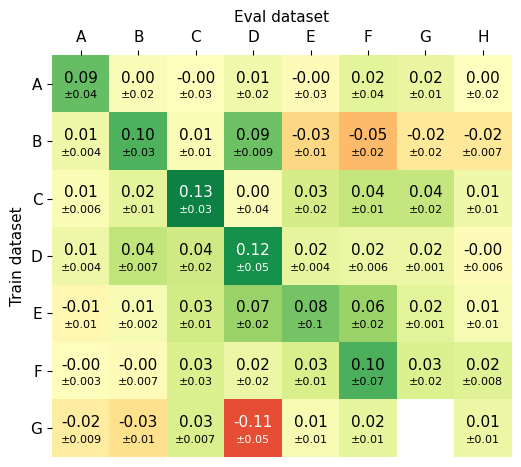

In [1051]:
fig, ax = draw_heatmap(xeval_sm_df, bl_df, same_eval_sm_df, 'average_precision', fixed_order=True, use_labels=True)
plt.grid(False)
#ax.set_title('With fixed size training sets')
#fig.savefig('../../report/latex/figures/xeval-sm-heatmap.pdf')

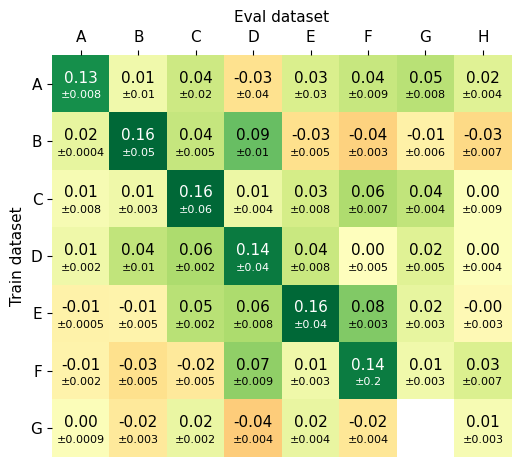

In [1050]:
fig, ax = draw_heatmap(xeval_lg_df, bl_df, same_eval_lg_df, 'average_precision', fixed_order=True)
#fig.savefig('../../report/latex/figures/xeval-lg-heatmap.pdf')
plt.grid(False)
#fig.savefig('../../report/latex/figures/xeval-lg-heatmap.svg')


In [35]:
grid_lg, _, _ = draw_heatmap(xeval_lg_df, bl_df, 'average_precision', fixed_order=True, no_plot=True)
grid_sm, _, _ = draw_heatmap(xeval_sm_df, bl_df, 'average_precision', fixed_order=True, no_plot=True)

In [119]:
(grid_sm[~np.isnan(grid_sm)] > 0).sum()


36

In [497]:
def get_best_adapters_for_review(review, xeval_df, seed=None, exclude_seed=None, only_pos=False, split=None, metric='average_precision'):
    assert (exclude_seed is None) != (seed is None), 'Must provide exclude_seed XOR seed'

    if seed is not None:
        rows = xeval_df[
            (xeval_df.eval_review == review)
            & (xeval_df.adapters_seed == seed)
        ]
    else:
        rows = xeval_df[
            (xeval_df.eval_review == review)
            & (xeval_df.adapters_seed != exclude_seed)
        ]
        print(f'Found {len(rows)} matching rows')
        
        rows = rows.groupby(['name','train_review']).mean(
            [metric, f'split_a_{metric}', f'split_b_{metric}']
        )

    if only_pos:
        baseline = bl_df.loc[review][metric]
        rows = rows[rows[metric] > baseline]

    if split is not None:
        rank_by = f'{split}_{metric}'
    else:
        rank_by = metric
        
    ranked = rows.sort_values(rank_by, ascending=False)
    if exclude_seed is not None:
        adapters_for_seed = xeval_df[
            xeval_df.adapters_seed == exclude_seed
        ].groupby('train_review').agg({'trained_model': 'unique'})
        ranked = ranked.join(adapters_for_seed)
        return ranked[['trained_model', metric]]

        
    return ranked[['name', 'train_review', 'trained_model', metric]]
    

In [498]:
get_best_adapters_for_review(117787, xeval_sm_df, seed=3)

,name,train_review,trained_model,average_precision
71,lily-117,334317,tberm-org/ft-small/model-lily-sm:v3,0.593977
5,poppy-117,165805,tberm-org/ft-small/model-poppy-sm:v2,0.578138
97,hyacinth-117,258698,tberm-org/ft-small/model-hyacinth-sm:v3,0.577729
79,iris-117,378562,tberm-org/ft-small/model-iris-sm:v3,0.559343
96,daffodil-117,121733,tberm-org/ft-small/model-daffodil-sm:v2,0.555029
118,edelweiss-117,287708,tberm-org/ft-small/model-edelweiss-sm:v3,0.516073


Trying to get an idea of the extent to which the ranking of training datasets is fixed across eval datasets.

In [259]:
from itertools import combinations
from scipy.stats import spearmanr

review_ids = bl_df.index
min_corrs = []
for eval_review in review_ids:
    ranks = []
    for i in range(1, 4):
        ranks.append(get_best_adapters_for_review(eval_review, xeval_sm_df, i).train_review.argsort())

    corrs = []
    for rank1, rank2 in combinations(ranks, 2):
        corrs.append(spearmanr(rank1, rank2).statistic)
    min_corrs.append(min(corrs))

np.mean(min_corrs)

0.4419642857142858

### Analysing review similarity

* We have values of a range of similarity metrics between reviews stored in `similarity_metrics/`
* Visualise them and analyse how well they predict the learning transfer between the reviews

In [268]:
import numpy as np
from ast import literal_eval

criteria_sims = np.genfromtxt('similarity_data/criteria_sims.txt')
paper_sims = np.genfromtxt('similarity_data/paper_sims.txt')

with open('similarity_data/criteria_sims_review_ids.txt') as file:
    criteria_sims_review_ids = literal_eval(file.read())

with open('similarity_data/paper_sims_review_ids.txt') as file:
    paper_sims_review_ids = [int(id) for id in literal_eval(file.read())]

In [939]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def draw_similarity_heatmap(values, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap='BuPu')
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    ax.spines[:].set_visible(False)
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # text annotations.
    max_val = values.max()
    min_val = values.min()
    scale = np.abs(values).max()
    for i in range(len(labels)):
        for j in range(len(labels)):
            val = values[i, j]
            if np.abs(val) < 0.5 * scale:
                text_color = 'k'
            else:
                text_color = 'w'
            text = ax.text(
                j, i, f'{val:.2f}', ha="center", va="center",
                color=text_color
            )

    fig.tight_layout()
    fig.show()
    return fig, ax

/tmp/ipykernel_248331/265200826.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 640x480 with 1 Axes>, <Axes: >)

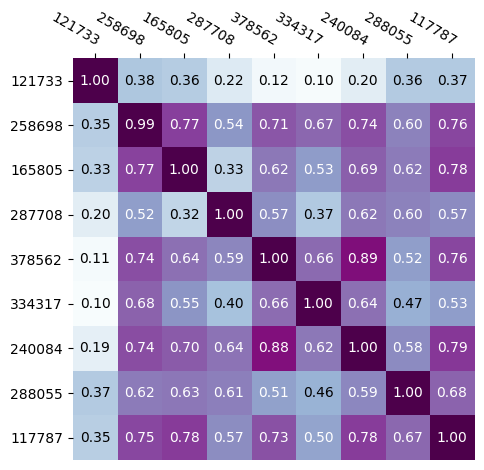

In [145]:
draw_similarity_heatmap(paper_sims, paper_sims_review_ids)

/tmp/ipykernel_248331/265200826.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 640x480 with 1 Axes>, <Axes: >)

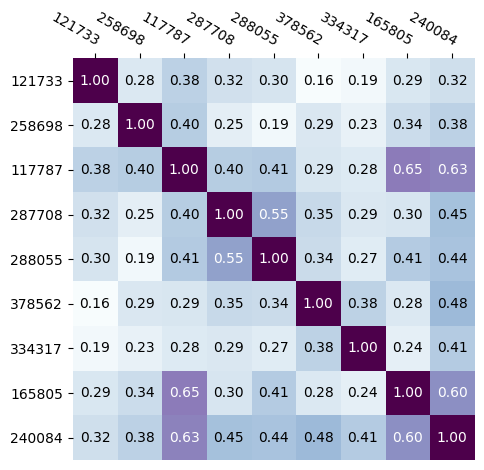

In [146]:
draw_similarity_heatmap(criteria_sims, criteria_sims_review_ids)

**Comparison of transfer versus training dataset size**

Spearman corr: SignificanceResult(statistic=0.21428571428571433, pvalue=0.6445115810207203)
Pearson corr: PearsonRResult(statistic=0.34164763742702864, pvalue=0.45324941714474465)


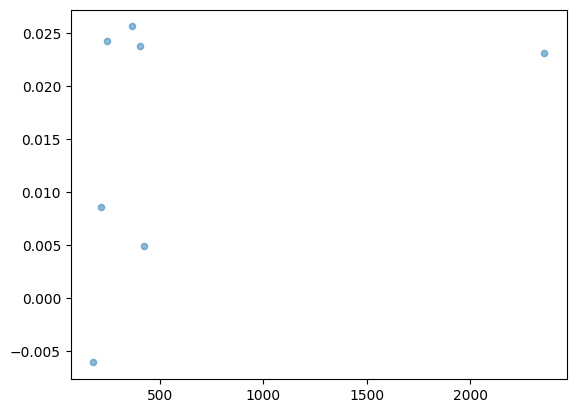

In [542]:
grid, row_labels, col_labels = draw_heatmap(xeval_lg_df, bl_df, 'average_precision', no_plot=True)

row_means = np.nanmean(grid, axis=1)
sizes = []
for review_id in row_labels:
    full_df = pd.read_csv(f'../data/covidence/review_{review_id}/full.csv', index_col=0)
    train_idx = np.genfromtxt(f'../data/covidence/review_{review_id}/balanced_train_split.txt')
    train_df = full_df.loc[train_idx]
    sizes.append(len(train_df))

plt.scatter(sizes, row_means, s=20, alpha=0.5)
    
print('Spearman corr:', stats.spearmanr(sizes, row_means))
print('Pearson corr:', stats.pearsonr(sizes, row_means))

**Checking whether there is some symmetry to the degree of transfer**

I.e., is there a correlation between the transfer when training on A and evaluating on B, and when training on B and evaluating on A?

Spearman corr: SignificanceResult(statistic=0.6077922077922078, pvalue=0.0034698523902231206)
Pearson corr: PearsonRResult(statistic=0.39636543723199597, pvalue=0.07526615934850528)


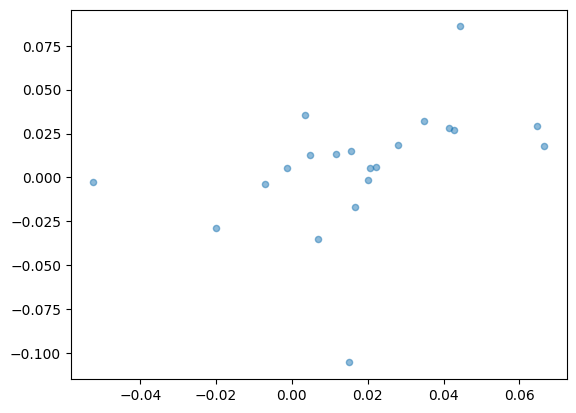

In [411]:
fig, ax, grid, row_labels, col_labels = draw_heatmap(xeval_sm_df, bl_df, 'average_precision', no_plot=True)

transfer_right = []
transfer_left = []
for review_a, review_b in combinations(review_ids, 2):
    rows_right = xeval_sm_df[
        (xeval_sm_df.train_review == review_a)
        & (xeval_sm_df.eval_review == review_b)
    ]
    score_right = rows_right.average_precision.mean()
    bl_right = bl_df.loc[review_b, 'average_precision']
    transfer_right.append(score_right - bl_right)
    
    rows_left = xeval_sm_df[
        (xeval_sm_df.train_review == review_b)
        & (xeval_sm_df.eval_review == review_a)
    ]
    score_left = rows_left.average_precision.mean()
    bl_left = bl_df.loc[review_a, 'average_precision']
    transfer_left.append(score_left - bl_left)

plt.scatter(transfer_right, transfer_left, s=20, alpha=0.5)
    
print('Spearman corr:', stats.spearmanr(transfer_right, transfer_left))
print('Pearson corr:', stats.pearsonr(transfer_right, transfer_left))

Spearman corr: SignificanceResult(statistic=0.5116883116883117, pvalue=0.017736397243725104)
Pearson corr: PearsonRResult(statistic=0.40438004194496635, pvalue=0.06903464375234852)


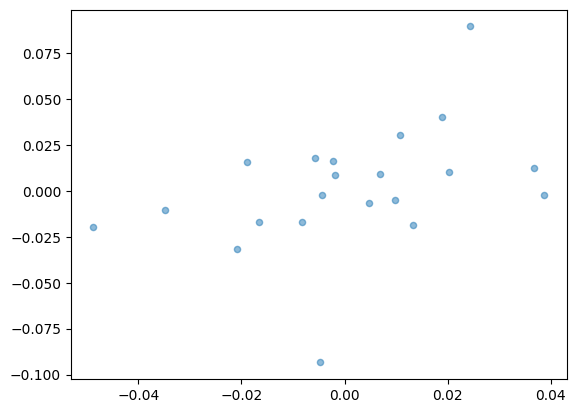

In [432]:
grid, row_labels, col_labels = draw_heatmap(xeval_sm_df, bl_df, 'average_precision', no_plot=True)
row_labels = row_labels.tolist()
col_labels = col_labels.tolist()

transfer_right = []
transfer_left = []
for review_a, review_b in combinations(review_ids, 2):
    row_index = row_labels.index(review_a)
    col_index = row_labels.index(review_b)
    right = grid[row_index, col_index]
    train_av = grid[row_index, [i for i in range(len(col_labels)) if i != row_index]].mean()
    transfer_right.append(right - train_av)

    row_index = row_labels.index(review_b)
    col_index = row_labels.index(review_a)
    left = grid[row_index, col_index]
    train_av = grid[row_index, [i for i in range(len(col_labels)) if i != row_index]].mean()

    transfer_left.append(left - train_av)

plt.scatter(transfer_right, transfer_left, s=20, alpha=0.5)
    
print('Spearman corr:', stats.spearmanr(transfer_right, transfer_left))
print('Pearson corr:', stats.pearsonr(transfer_right, transfer_left))

In [982]:
import sys
sys.path.append('..')
from run_common import load_reviews, init_config
from scipy import stats

init_config()

def scatter_with_similarity(sims_file, ids_file=None, ids_list=None, seed=None, figsize=(9,6)):
    if ids_list is not None:
        review_ids = ids_list
    elif ids_file is not None:
        with open(ids_file) as file:
            review_ids = [int(id) for id in literal_eval(file.read())]
    else:
        review_ids = load_reviews().index

    sims = np.genfromtxt(sims_file)
    
    flat_scores = []
    flat_sims = []
    flat_reviews = []
    for i, train_review in enumerate(review_ids):
        if train_review in (240084, 288055):
            continue
        for j, eval_review in enumerate(review_ids):
            if eval_review == 240084:
                continue
            if train_review == eval_review:
                continue
                
            rows = xeval_sm_df[
                (xeval_sm_df.train_review == train_review)
                & (xeval_sm_df.eval_review == eval_review)
            ]
            if seed is not None:
                rows = rows[rows.adapters_seed == seed]
            
            xeval_score = rows.average_precision.mean()
            baseline = bl_df.loc[eval_review, 'average_precision']
            flat_scores.append(xeval_score - baseline)

            flat_sims.append(sims[i,j])
            flat_reviews.append(eval_review)
    
    flat_scores = np.array(flat_scores)
    flat_sims = np.array(flat_sims)
    cmap = {review: f'C{i}' for i, review in enumerate(review_ids)}
    flat_colors = [cmap.get(rev) for rev in flat_reviews]

    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(flat_sims, flat_scores, s=30, alpha=0.5, c=flat_colors)

    ax.spines[["top", "right"]].set_visible(False)
    
    print('Spearman corr:', spearmanr(flat_sims, flat_scores))
    print('Pearson corr:', pearsonr(flat_sims, flat_scores))

    return flat_sims, flat_scores, fig, ax

Using config from /home/tom/msc/diss/experiments/notebooks/../configs/local.yaml


In [1009]:
from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr, binom

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

ids_file = 'similarity_data/paper_sims_review_ids.txt'
sims_file = 'similarity_data/paper_sims.txt'
target_review = 378562

def get_ranking_scores(sims_file, ids_file=None, ids_list=None, seed=None):
    if ids_list is not None:
        review_ids = ids_list
    elif ids_file is not None:
        with open(ids_file) as file:
            review_ids = [int(id) for id in literal_eval(file.read())]
    else:
        review_ids = load_reviews().index
    
    train_idxs, train_reviews = list(zip(*[(i, idx) for i, idx in enumerate(review_ids) if idx not in (240084, 288055)]))
    eval_idxs, eval_reviews = list(zip(*[(i, idx) for i, idx in enumerate(review_ids) if idx != 240084]))
    train_idxs = np.array(train_idxs)
    eval_idxs = np.array(eval_idxs)
    train_reviews = np.array(train_reviews)
    eval_reviews = np.array(eval_reviews)
    
    sims = np.genfromtxt(sims_file)
    
    sims = sims[train_idxs][:, eval_idxs]

    #fig, ax = plt.subplots(3,3)
    #axes = [a for row in ax for a in row] 
    
    out = []
    num_hits = 0
    num_hits_reversed = 0
    num_chances = 0
    p = 0.5
    for i, target_review in enumerate(eval_reviews):
        stats = {}
        here_train_idxs = [i for i, rev in enumerate(train_reviews) if rev != target_review]
        here_train_reviews = [rev for i, rev in enumerate(train_reviews) if rev != target_review]
        sims_for_target = sims[here_train_idxs, i]
        evals_for_target = xeval_sm_df[xeval_sm_df.eval_review == target_review]
        if seed is not None:
            evals_for_target = evals_for_target[evals_for_target.adapters_seed == seed]
        baseline = bl_df.loc[target_review, 'average_precision']
        evals_for_target['score_diff'] = evals_for_target.average_precision - baseline
        scores_for_target = evals_for_target.groupby('train_review').score_diff.mean()
        # sort to match sims column
        scores_for_target = scores_for_target[here_train_reviews].to_numpy()
        stats['spearmanr'] = spearmanr(scores_for_target, sims_for_target).statistic

        top_3_scores = scores_for_target.argsort()[:3]
        top_3_sims = sims_for_target.argsort()[:3]
        stats['top_3_hits'] = len(set(top_3_scores) & set(top_3_sims))
        #bot_3_sims = sims_for_target.argsort()[-3:]
        
        #if (3 / len(scores_for_target)) == p:
        #    # prob of getting this many top3 hits or better with random guessing
        #    num_hits += len(set(top_3_scores) & set(top_3_sims))
        #    num_hits_reversed += len(set(top_3_scores) & set(bot_3_sims))
        #    num_chances += 3
        #    stats['top_3_acc'] = len(set(top_3_scores) & set(top_3_sims)) / 3
        #    stats['bot_3_acc'] = len(set(top_3_scores) & set(bot_3_sims)) / 3


        #else:
        #    print(f'Not counting review {target_review} in null hyp since p would be different')
        
        out.append(stats)
        #sims_for_target = sims_for_target[scores_for_target > 0]
        #scores_for_target = scores_for_target[scores_for_target > 0]
        #print(ndcg_score(scores_for_target.reshape(1,-1), sims_for_target.reshape(1,-1)))
        #axes[i].scatter(sims_for_target, scores_for_target)

    #null_prob = binom.sf(num_hits - 1, num_chances, p)    
    #print('Probability of this num. hits through random guessing:', null_prob)

    #null_prob = binom.sf(num_hits_reversed - 1, num_chances, p)    
    #print('Probability of num. hits from inverse score through random guessing:', null_prob)
    
    return pd.DataFrame(out)

In [975]:
get_ranking_scores('similarity_data/paper_sims.txt', 'similarity_data/paper_sims_review_ids.txt').mean()

Not counting review 288055 in null hyp since p would be different
Probability of this num. hits through random guessing: 0.19165515899658203


spearmanr    0.148214
top_3_acc    0.583333
dtype: float64

In [537]:
def get_most_similar_reviews(target_review, sims_file, ids_file):
    with open(ids_file) as file:
        review_ids = [int(id) for id in literal_eval(file.read())]
    
    sims = np.genfromtxt(sims_file)
    review_idx = review_ids.index(target_review)
    review_sims = sims[review_idx]
    sorter = review_sims.argsort()
    return pd.DataFrame({
        'review': np.array(review_ids)[sorter],
        'similarity': review_sims[sorter],
    }).sort_values('similarity', ascending=False).iloc[1:]


In [1037]:
get_most_similar_reviews(
    ids_file = 'similarity_data/paper_sims_review_ids.txt',
    sims_file = 'similarity_data/paper_sims.txt',
    target_review = 240084,
)

,review,similarity
7,378562,0.883919
6,117787,0.793593
5,258698,0.738099
4,165805,0.700605
3,287708,0.637959
2,334317,0.624453
1,288055,0.576437
0,121733,0.186145


Spearman corr: SignificanceResult(statistic=0.2737755102040816, pvalue=0.05697531629854889)
Pearson corr: PearsonRResult(statistic=0.13335471349727565, pvalue=0.3609933297034786)


spearmanr     0.148214
top_3_hits    1.750000
dtype: float64

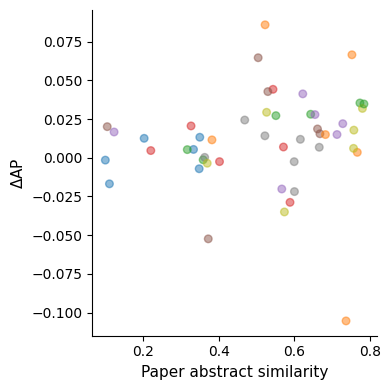

In [1025]:
flat_paper_sims, flat_scores, fig, ax = scatter_with_similarity('similarity_data/paper_sims.txt', ids_file='similarity_data/paper_sims_review_ids.txt', figsize=(4,4))
ax.set_xlabel('Paper abstract similarity', fontsize=11)
ax.set_ylabel(r'$\Delta$AP', fontsize=11)
fig.tight_layout()
#fig.savefig('../../report/latex/figures/paper_sim_scatter.pdf')
get_ranking_scores('similarity_data/paper_sims.txt', 'similarity_data/paper_sims_review_ids.txt').mean()

Spearman corr: SignificanceResult(statistic=-0.15731313529191615, pvalue=0.2803634735802524)
Pearson corr: PearsonRResult(statistic=0.001139302811491806, pvalue=0.9938011085865069)
spearmanr    -0.034821
top_3_hits    1.625000
dtype: float64


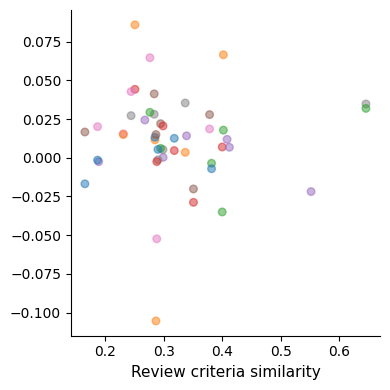

In [1026]:
flat_criteria_sims, flat_scores, fig, ax = scatter_with_similarity('similarity_data/criteria_sims.txt', ids_file='similarity_data/criteria_sims_review_ids.txt', figsize=(4,4))
ax.set_xlabel('Review criteria similarity', fontsize=11)
print(get_ranking_scores('similarity_data/criteria_sims.txt', 'similarity_data/criteria_sims_review_ids.txt').mean())
# ax.set_ylabel(r'$\Delta$AP', fontsize=11)
fig.tight_layout()
fig.savefig('../../report/latex/figures/criteria_sim_scatter.pdf')

Spearman corr: SignificanceResult(statistic=-0.3044400702716433, pvalue=0.03343351145439991)
Pearson corr: PearsonRResult(statistic=-0.1281268370588767, pvalue=0.3802919751236443)
spearmanr    -0.189437
top_3_hits    1.375000
dtype: float64


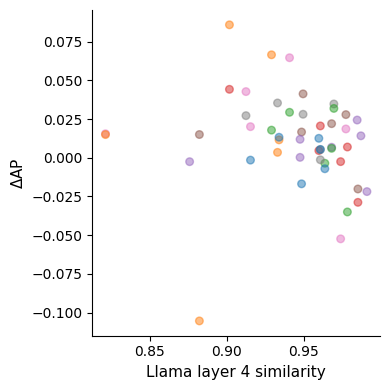

In [1027]:
flat_layer4_sims, flat_scores, fig, ax = scatter_with_similarity('similarity_data/layer4_sims.txt')
ax.set_xlabel('Llama layer 4 similarity', fontsize=11)
ax.set_ylabel(r'$\Delta$AP', fontsize=11)
fig.tight_layout()
print(get_ranking_scores('similarity_data/layer4_sims.txt').mean())
fig.savefig('../../report/latex/figures/layer4_sim_scatter.pdf')

Spearman corr: SignificanceResult(statistic=0.13619890860411488, pvalue=0.3507484781947463)
Pearson corr: PearsonRResult(statistic=0.004517327466096432, pvalue=0.9754249619987385)


spearmanr     0.144948
top_3_hits    1.750000
dtype: float64

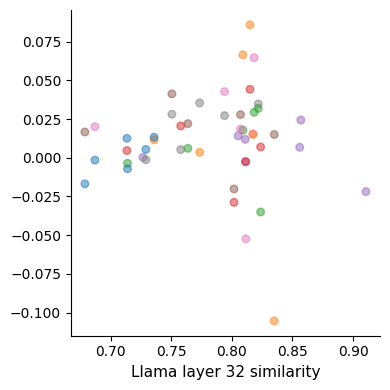

In [1013]:
_, _, fig, ax = scatter_with_similarity('similarity_data/layer32_sims.txt')
ax.set_xlabel('Llama layer 32 similarity', fontsize=11)
#ax.set_ylabel(r'$\Delta$AP', fontsize=11)
fig.tight_layout()
fig.savefig('../../report/latex/figures/layer32_sim_scatter.pdf')
get_ranking_scores('similarity_data/layer32_sims.txt').mean()

Probability of this num. hits through random guessing: 0.03195732831954956


,spearmanr,top_3_acc
0,-0.085714,0.666667
1,0.142857,0.666667
2,0.142857,0.666667
3,-0.257143,0.666667
4,0.028989,0.666667
5,0.085714,0.666667
6,0.200000,0.666667
7,0.828571,1.000000


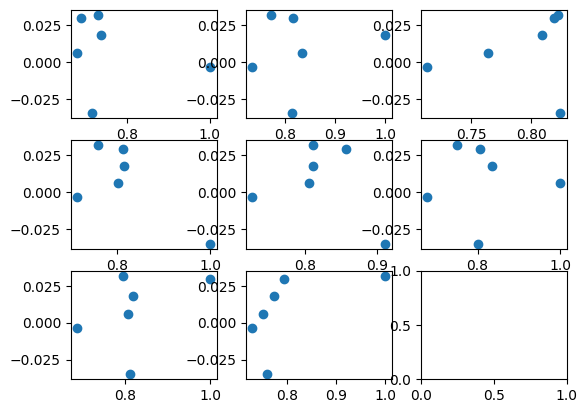

In [943]:
get_ranking_scores('similarity_data/layer32_sims.txt')

/tmp/ipykernel_446699/1343173353.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(<Figure size 640x480 with 1 Axes>, <Axes: >)

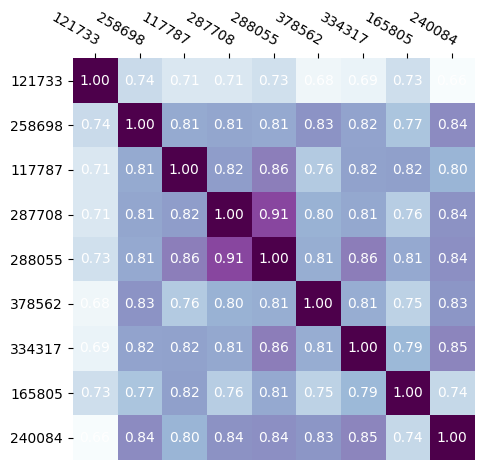

In [940]:
grid_array = np.genfromtxt('similarity_data/layer32_sims.txt')
review_ids = load_reviews().index
draw_similarity_heatmap(grid_array, review_ids)


Spearman corr: SignificanceResult(statistic=-0.28692531949955785, pvalue=0.04562182860334966)
Pearson corr: PearsonRResult(statistic=-0.11653137648666975, pvalue=0.4252282211859985)


spearmanr   -0.350991
top_3_acc    0.375000
dtype: float64

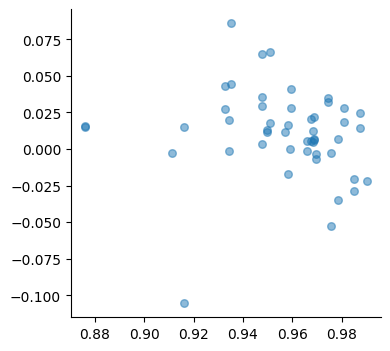

In [805]:
scatter_with_similarity('similarity_data/layer4_sims_instruct.txt')
get_ranking_scores('similarity_data/layer4_sims_instruct.txt').mean()

Spearman corr: SignificanceResult(statistic=-0.1870900495915077, pvalue=0.19801673441954004)
Pearson corr: PearsonRResult(statistic=-0.08438886199055345, pvalue=0.5642757054044648)


spearmanr   -0.200
top_3_acc    0.375
dtype: float64

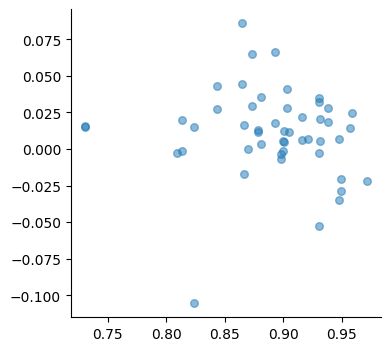

In [806]:
scatter_with_similarity('similarity_data/layer8_sims.txt')
get_ranking_scores('similarity_data/layer8_sims.txt').mean()

wandb:   1 of 1 files downloaded.  


Spearman corr: SignificanceResult(statistic=0.03276429556601881, pvalue=0.8368033586811823)
Pearson corr: PearsonRResult(statistic=0.09238856685764647, pvalue=0.5606179451636815)


spearmanr     0.069388
top_3_hits    1.714286
dtype: float64

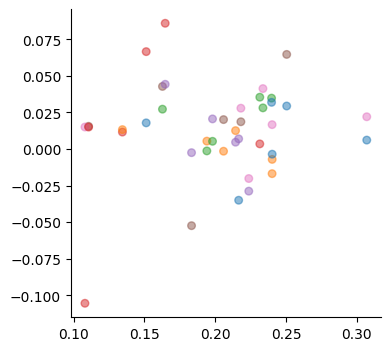

In [1024]:
#run = api.run("tberm-org/adapter-comparison/i40by72b")
#review_ids = [get_review_from_model_name(model) for model in run.summary['adapters']]

review_ids = [117787, 121733, 165805, 258698, 287708, 334317, 378562]
artifact = api.artifact("tberm-org/adapter-comparison/cosine_similarities:v16")
artifact_dir = artifact.download()
sims_file = artifact_dir + '/cosine_similarities.txt'
grid_array = np.genfromtxt(sims_file)
#draw_similarity_heatmap(grid_array, review_ids)
scatter_with_similarity(artifact_dir + '/cosine_similarities.txt', ids_list=review_ids)
get_ranking_scores(artifact_dir + '/cosine_similarities.txt', ids_list=review_ids).mean()

wandb:   1 of 1 files downloaded.  


Spearman corr: SignificanceResult(statistic=-0.2569239810721475, pvalue=0.10048401460883735)
Pearson corr: PearsonRResult(statistic=-0.07837879750784113, pvalue=0.6217416143470289)


spearmanr    -0.053061
top_3_hits    1.428571
dtype: float64

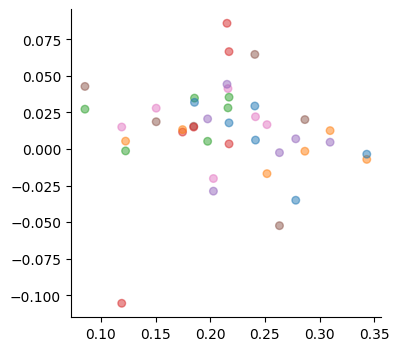

In [1023]:
#run = api.run("tberm-org/adapter-comparison/i40by72b")
#review_ids = [get_review_from_model_name(model) for model in run.summary['adapters']]

review_ids = [117787, 121733, 165805, 258698, 287708, 334317, 378562]
artifact = api.artifact("tberm-org/adapter-comparison/cosine_similarities:v20")
artifact_dir = artifact.download()
sims_file = artifact_dir + '/cosine_similarities.txt'
grid_array = np.genfromtxt(sims_file)
#draw_similarity_heatmap(grid_array, review_ids)
scatter_with_similarity(artifact_dir + '/cosine_similarities.txt', ids_list=review_ids)
get_ranking_scores(artifact_dir + '/cosine_similarities.txt', ids_list=review_ids).mean()

In [81]:
flat_paper_sims.shape, np.array(flat_scores).shape

((64,), (49,))

Functions used to retrospectively add additional metrics to evaluations in wandb runs

In [7]:
def add_pos_rate_to_eval_run(run):
    results_art = [art for art in run.logged_artifacts() if 'Eval' in art.name][0]
    table = results_art.get('Eval results')
    results_df = pd.DataFrame(data=table.data, columns=table.columns).set_index('index')
    pos_rate = results_df.predicted_label.mean()
    run.summary['pos_rate'] = pos_rate
    run.summary.update()

def add_cal_f1_to_eval_run(run):
    results_art = [art for art in run.logged_artifacts() if 'Eval' in art.name][0]
    table = results_art.get('Eval results')
    results_df = pd.DataFrame(data=table.data, columns=table.columns).set_index('index')
    run.summary['cal_f1'] = cal_f1(results_df)
    run.summary.update()

def add_neg_recall_to_eval_run(run):
    results_art = [art for art in run.logged_artifacts() if 'Eval' in art.name][0]
    table = results_art.get('Eval results')
    results_df = pd.DataFrame(data=table.data, columns=table.columns).set_index('index')
    neg_egs = results_df[results_df.label != 1]
    run.summary['neg_recall'] = (neg_egs.predicted_label != 1).mean()
    run.summary.update()


from sklearn.metrics import average_precision_score
from ast import literal_eval

def add_av_prec_to_eval_run(run):
    results_art = [art for art in run.logged_artifacts() if 'Eval' in art.name][0]
    table = results_art.get('Eval results')
    results_df = pd.DataFrame(data=table.data, columns=table.columns).set_index('index')
    
    results_df['pos_prob'] = results_df.label_probs.apply(lambda p: literal_eval(p)[1])
    ap = average_precision_score(results_df.label, results_df.pos_prob)
    run.summary['average_precision'] = ap
    run.summary.update()


### Analysing how well performance on a few-shot dataset predicts performance on a large dataset

In [590]:
api = wandb.Api()
runs = [run for run in api.runs('tberm-org/multi-review-ft')
        if run.config['run_config']['eval_set'].split('/')[-1] in ('trunc_full.txt', 'full.csv')
        and 'manual' not in run.tags and 'double-run' not in run.tags]

In [349]:
mt_review_runs = {}
for run in runs:
    review_id = get_review_from_eval_set(run.config['run_config']['eval_set'])
    if review_id not in mt_review_runs:
        mt_review_runs[review_id] = run

In [331]:
fs_review_runs = {}
runs = [run for run in api.runs('tberm-org/few-shot-ft')
        if run.config['train_config'].get('seed') == 1]

for run in runs:
    review_id = get_review_from_eval_set(run.config['train_config']['train_set'])
    if review_id not in fs_review_runs:
        fs_review_runs[review_id] = run

In [354]:
config_dicts = []
for review, run in mt_review_runs.items():
    cd = {}
    mt_model = get_model_from_run(run)
    cd['mt_adapter'] = mt_model.name
    fs_run = fs_review_runs[review]
    fs_model = get_model_from_run(fs_run)
    cd['few_shot_adapter'] = fs_model.name
    run_name = re.search(r'model-(.*):v\d+', latest.name).groups()[0]
    cd['run_name'] = run_name
    cd['review'] = review
    cd['review_short'] = str(review)[:3]
    for mt_weight in (0.2, 0.5, 0.8):
        this_cd = cd.copy()
        this_cd['mt_adapter_weight'] = mt_weight
        this_cd['few_shot_adapter_weight'] = 1 - mt_weight
        config_dicts.append(this_cd)

In [361]:
api = wandb.Api()
runs = [run for run in api.runs('tberm-org/adapter-soup')
        if run.config['run_config']['eval_set'].split('/')[-1] in ('trunc_full.txt', 'full.csv')
        and run.config['run_config']['adapters_seed'] == 1
        and 'top' in run.name]

In [362]:
mod_review_runs = {}

for run in runs:
    review_id = get_review_from_eval_set(run.config['run_config']['eval_set'])
    if review_id not in mod_review_runs:
        mod_review_runs[review_id] = run

In [364]:
run = mod_review_runs[287708]
run.config['run_config']['load_multi_adapters']

{'tberm-org/ft-small/model-poppy-sm:v8': 1,
 'tberm-org/ft-small/model-bluebell-sm:v7': 1,
 'tberm-org/ft-small/model-hyacinth-sm:v7': 1}

In [365]:
config_dicts = []
for review, run in mod_review_runs.items():
    cd = {}
    
    adapters = run.config['run_config']['load_multi_adapters']
    for i, adapter in enumerate(adapters.keys()):
        cd[f'adapter{i}'] = adapter
        
    fs_run = fs_review_runs[review]
    fs_model = get_model_from_run(fs_run)
    cd['few_shot_adapter'] = fs_model.name
    
    run_name = re.search(r'model-(.*):v\d+', latest.name).groups()[0]
    cd['run_name'] = run_name
    cd['review'] = review
    cd['review_short'] = str(review)[:3]
    for fs_weight in (0.2, 0.5, 0.8):
        this_cd = cd.copy()
        this_cd['few_shot_adapter_weight'] = fs_weight
        others_weight = round((1 - fs_weight) / 3, 3)
        this_cd['pre_trained_adapters_weight'] = others_weight
        config_dicts.append(this_cd)

In [433]:
xeval_runs = [ run for run in api.runs('tberm-org/cross-review-eval-sm')
              if run.config['run_config'].get('adapters_seed') is not None]

xeval_seed1_runs = [
    run for run in xeval_runs
    if run.config['run_config'].get('adapters_seed') == 1
]

In [500]:
len(xeval_runs)

168

In [393]:
run = xeval_seed1_runs[0]

In [398]:
run.config['run_config']['eval_set'], get_review_from_model_name(run.config['run_config']['load_adapter'])

('data/covidence/review_378562/full.csv', 334317)

In [403]:
run.config['run_config']['eval_set']

'data/covidence/review_378562/full.csv'

In [443]:
def compute_metrics(df):
    acc = (df.predicted_label == df.label).mean()
    ap = average_precision_score(df.label, df.pos_prob)
    tp = sum((df.label == 1) & (df.predicted_label == 1))
    fp = sum((df.label != 1) & (df.predicted_label == 1))
    tn = sum((df.label != 1) & (df.predicted_label != 1))
    fn = sum((df.label == 1) & (df.predicted_label != 1))
    prec = tp / (tp + fp) if tp + fp > 0 else 0
    rec = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = (2 * prec * rec) / (prec + rec) if prec + rec > 0 else 0
    neg_recall = tn / (tn + fp) if tn + fp > 0 else 0
    pos_rate = df.predicted_label.mean()
    out = {
        'acc': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'neg_recall': neg_recall,
        'pos_rate': pos_rate,
        'average_precision': ap,
    }
    return out


In [444]:
from ast import literal_eval

few_shot_eval_results = []

for run in xeval_runs:
    train_review = get_review_from_model_name(run.config['run_config']['load_adapter'])
    eval_review = get_review_from_eval_set(run.config['run_config']['eval_set'])
    if train_review == eval_review:
        continue
    if eval_review == 288055:
        continue
    results_df = get_results_df_for_run(run)
    results_df['pos_prob'] = results_df.label_probs.apply(lambda p: literal_eval(p)[1])

    fs_results = pd.concat([
        results_df[results_df.label == 1].sample(25),
        results_df[results_df.label == 0].sample(25),
    ])    
    ms_results = results_df.drop(index=fs_results.index)
    
    assert len(fs_results) + len(ms_results) == len(results_df)
    assert len(set(fs_results.index) & set(ms_results.index)) == 0
    
    few_shot_metrics = compute_metrics(fs_results)
    many_shot_metrics = compute_metrics(ms_results)
    full_metrics = compute_metrics(results_df)

    result = {
        'adapters_seed': run.config['run_config']['load_adapter'],
        'seed': run.config['run_config']['adapters_seed'],
        'eval_set': run.config['run_config']['eval_set'], 
        'train_review': train_review,
        'eval_review': eval_review,
        'few_shot_average_precision': few_shot_metrics['average_precision'],
        'many_shot_average_precision': many_shot_metrics['average_precision'],
        'full_average_precision': full_metrics['average_precision'],
        'few_shot_acc': few_shot_metrics['acc'],
        'many_shot_acc': many_shot_metrics['acc'],
        'full_acc': full_metrics['acc'],
        'few_shot_f1': few_shot_metrics['f1'],
        'many_shot_f1': many_shot_metrics['f1'],
        'full_f1': full_metrics['f1'],
    }
    few_shot_eval_results.append(result)
        

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo

In [510]:
models_to_seeds = {}
for run in xeval_runs:
    model = run.config['run_config']['load_adapter']
    seed = run.config['run_config']['adapters_seed']
    if model in models_to_seeds:
        assert models_to_seeds[model] == seed
    else:
        models_to_seeds[model] = seed

In [446]:
few_shot_eval_df = pd.DataFrame(few_shot_eval_results)

In [877]:
from ast import literal_eval

nat_few_shot_eval_results = []

for run in xeval_runs:
    train_review = get_review_from_model_name(run.config['run_config']['load_adapter'])
    eval_review = get_review_from_eval_set(run.config['run_config']['eval_set'])
    if train_review == eval_review:
        continue
    if eval_review == 288055:
        continue

    results_df = get_results_df_for_run(run)
    results_df['pos_prob'] = results_df.label_probs.apply(lambda p: literal_eval(p)[1])
    
    for i in range(100):
        fs_results = results_df.sample(50)
        if fs_results.label.sum() < 5:
            fs_results = pd.concat([
                results_df[results_df.label == 1].sample(5),
                results_df[results_df.label == 0].sample(45),
            ]).sample(frac=1)       
            
        ms_results = results_df.drop(index=fs_results.index)
        
        assert len(fs_results) + len(ms_results) == len(results_df)
        assert len(set(fs_results.index) & set(ms_results.index)) == 0
        
        few_shot_metrics = compute_metrics(fs_results)
        many_shot_metrics = compute_metrics(ms_results)
        full_metrics = compute_metrics(results_df)
    
        result = {
            'adapters_seed': run.config['run_config']['load_adapter'],
            'eval_set': run.config['run_config']['eval_set'], 
            'train_review': train_review,
            'eval_review': eval_review,
            'few_shot_average_precision': few_shot_metrics['average_precision'],
            'many_shot_average_precision': many_shot_metrics['average_precision'],
            'full_average_precision': full_metrics['average_precision'],
            'few_shot_acc': few_shot_metrics['acc'],
            'many_shot_acc': many_shot_metrics['acc'],
            'full_acc': full_metrics['acc'],
            'few_shot_f1': few_shot_metrics['f1'],
            'many_shot_f1': many_shot_metrics['f1'],
            'full_f1': full_metrics['f1'],
            'repeat': i,
        }
        nat_few_shot_eval_results.append(result)
        

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downlo

In [831]:
nat_few_shot_eval_df = pd.DataFrame(nat_few_shot_eval_results)
nat_few_shot_eval_df

,adapters_seed,eval_set,train_review,eval_review,few_shot_average_precision,many_shot_average_precision,full_average_precision,few_shot_acc,many_shot_acc,full_acc,few_shot_f1,many_shot_f1,full_f1,repeat
0,tberm-org/ft-small/model-poppy-sm:v2,data/covidence/review_378562/full.csv,165805,378562,0.694415,0.647596,0.644814,0.82,0.774030,0.777605,0.666667,0.517986,0.531148,0
1,tberm-org/ft-small/model-poppy-sm:v2,data/covidence/review_378562/full.csv,165805,378562,0.606335,0.647291,0.644814,0.84,0.772344,0.777605,0.555556,0.529617,0.531148,1
2,tberm-org/ft-small/model-poppy-sm:v2,data/covidence/review_378562/full.csv,165805,378562,0.721961,0.639250,0.644814,0.70,0.784148,0.777605,0.545455,0.529412,0.531148,2
3,tberm-org/ft-small/model-poppy-sm:v2,data/covidence/review_378562/full.csv,165805,378562,0.496908,0.662226,0.644814,0.74,0.780776,0.777605,0.434783,0.539007,0.531148,3
4,tberm-org/ft-small/model-poppy-sm:v2,data/covidence/review_378562/full.csv,165805,378562,0.293213,0.679678,0.644814,0.68,0.785835,0.777605,0.333333,0.548043,0.531148,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,tberm-org/ft-small/model-edelweiss-sm:v5,data/covidence/review_117787/full.csv,287708,117787,0.821111,0.522126,0.531763,0.92,0.902344,0.903008,0.500000,0.418605,0.421525,5
1256,tberm-org/ft-small/model-edelweiss-sm:v5,data/covidence/review_117787/full.csv,287708,117787,0.518544,0.536199,0.531763,0.86,0.904687,0.903008,0.363636,0.424528,0.421525,6
1257,tberm-org/ft-small/model-edelweiss-sm:v5,data/covidence/review_117787/full.csv,287708,117787,0.727778,0.527274,0.531763,0.92,0.902344,0.903008,0.666667,0.407583,0.421525,7
1258,tberm-org/ft-small/model-edelweiss-sm:v5,data/covidence/review_117787/full.csv,287708,117787,0.860000,0.524447,0.531763,0.94,0.901563,0.903008,0.571429,0.416667,0.421525,8


In [519]:
nat_few_shot_eval_df.rename(columns={'seed': 'adapters_seed', 'adapter': 'trained_model'}, inplace=True)
nat_few_shot_eval_df['name'] = ''

In [672]:
few_shot_df = get_wandb_runs_table('tberm-org/nat-few-shot-ft')

In [675]:
def get_few_shot_model(review, seed):
    rows = few_shot_df[
        (few_shot_df['train_config/seed'] == seed) &
        (few_shot_df['train_config/lora_r'] == 4) &
        (few_shot_df['run_config/eval_set'].str.contains(str(review)))
    ]
    assert len(rows) == 1
    run = api.run('tberm-org/nat-few-shot-ft/' + rows.iloc[0].id)
    return get_model_from_run(run).name
    

Spearman corr: SignificanceResult(statistic=0.24906084752922478, pvalue=0.0007475706247398853)
Pearson corr: PearsonRResult(statistic=0.2906932896294262, pvalue=7.535262580803492e-05)


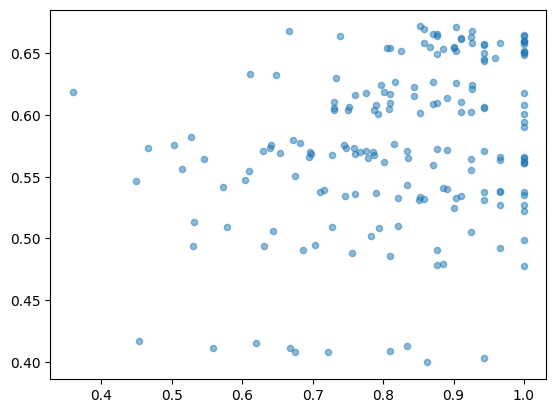

In [1036]:
from scipy.stats import pearsonr

fig, ax = plt.subplots()

rev_rows = nat_few_shot_eval_df[nat_few_shot_eval_df.eval_review == 258698]
#rev_rows = nat_few_shot_eval_df
x = rev_rows.few_shot_average_precision
y = rev_rows.many_shot_average_precision
plt.scatter(x, y, s=20, alpha=0.5)
print('Spearman corr:', spearmanr(x, y))
print('Pearson corr:', pearsonr(x, y))

In [861]:
nat_few_shot_eval_df.columns

Index(['adapters_seed', 'eval_set', 'train_review', 'eval_review',
       'few_shot_average_precision', 'many_shot_average_precision',
       'full_average_precision', 'few_shot_acc', 'many_shot_acc', 'full_acc',
       'few_shot_f1', 'many_shot_f1', 'full_f1', 'repeat'],
      dtype='object')

In [876]:
out = []
eval_reviews = nat_few_shot_eval_df.eval_review.unique()
train_reviews = nat_few_shot_eval_df.train_review.unique()

for i, target_review in enumerate(eval_reviews):
    rows = nat_few_shot_eval_df[nat_few_shot_eval_df.eval_review == target_review]

    sims = rows.few_shot_f1
    scores = rows.many_shot_average_precision
    
    stats['spearmanr'] = spearmanr(scores, sims).statistic

    top_3_scores = scores.argsort()[:3]
    top_3_sims = sims.argsort()[:3]
    stats['top_3_acc'] = len(set(top_3_scores) & set(top_3_sims)) / 3
    out.append(stats)

pd.DataFrame(out).mean()

spearmanr   -0.069324
top_3_acc    0.000000
dtype: float64